**Part 2. AI Agent 활용 프로젝트**

- Chapter 03. N개 이상의 Agent

    - **📒[실습]** Clip 06. Hierarchical - 웹 검색 기반 조사 + 문서 작성 전문가 Agent🗒️

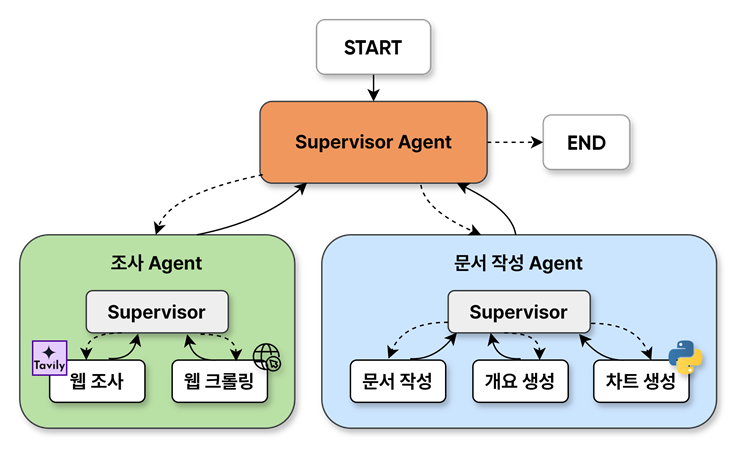

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

### 웹 검색을 위한 도구 설정

In [2]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


### 문서 작성을 위한 도구 설정

`create_outline` : 문서의 개요를 작성하는 도구

`read_document` : 문서를 불러와 읽는 도구

`write_document` : 문서를 작성하는 도구

`edit_document` : 문서를 수정하는 도구

`python_repl_tool` : 차트를 생성하는 도구

In [3]:
from typing import Dict, Optional
from typing_extensions import TypedDict

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with open(file_name, "w", encoding="utf-8") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with open(file_name, "r", encoding="utf-8") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with open(file_name, "w", encoding="utf-8") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with open(file_name, "r", encoding="utf-8") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with open(file_name, "w", encoding="utf-8") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


@tool
def python_exec_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = exec(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

### Supervisor 노드 설정

In [4]:
from typing import Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

### 웹 검색 Agent에 들어가는 Agent들 설정하기

- Tavily Tool ReAct Agent
- 웹 페이지 스크래핑 ReAct Agent

웹조사 Agent : [supervisor] - [tavily tool ReAct Agent]
                ㄴ [웹 크롤링 tool ReAct Agent]

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")
# 1)
search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        goto="supervisor", # 웹 조사 Agent 안에서의 작은 Supervisor
    )

In [6]:
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

# 2)
def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        goto="supervisor", # 웹 조사 Agent
    )

In [7]:
research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [8]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

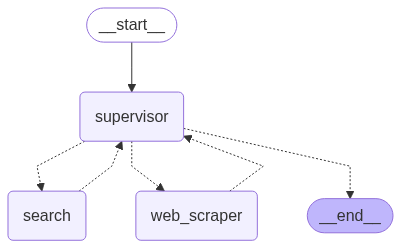

In [9]:
from IPython.display import Image, display

try:
    display(Image(research_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
for s in research_graph.stream(
    {"messages": [("user", "https://n.news.naver.com/mnews/article/018/0006019640 이 뉴스 기사는 어떤 내용인가요?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'web_scraper'}}
---
{'web_scraper': {'messages': [HumanMessage(content='이 뉴스 기사는 갑작스럽게 찾아온 초여름 더위로 인해 서울의 아침 최저 기온이 5월 중 역대 최고치를 기록했다는 내용을 담고 있습니다. 기사에 따르면, 서울의 이날 최저 기온은 23도로 1907년 이후 최고치를 경신했으며, 경북 포항은 5월 열대야를 가까스로 피했습니다. 이와 같은 현상의 원인으로는 일본 동쪽에 위치한 고기압으로 인한 따뜻한 남풍과 바다 안개, 승온 효과 등이 지적되고 있습니다. 기상청은 다음 날까지 높은 기온이 이어질 것으로 예상하고, 이후 금요일부터는 기온이 평년 수준으로 회복될 것이라는 전망을 내놓았습니다.', additional_kwargs={}, response_metadata={}, name='web_scraper', id='d3583803-3d69-4acc-90ac-40f2ae68a26c')]}}
---
{'supervisor': {'next': 'web_scraper'}}
---
{'web_scraper': {'messages': [HumanMessage(content='이 뉴스 기사는 서울에서 하루 최저기온이 1907년 관측 이래 5월 중 가장 높은 온도를 기록했으며, 경북 포항은 5월 열대야를 간신히 피했다는 내용을 다루고 있습니다. 기온 상승의 이유로는 따뜻한 남풍 및 안개, 승온효과 등이 지적되었습니다. 또한, 기상청은 이러한 현상이 다음 날까지 지속될 것으로 보이며, 이후 금요일부터는 기온이 평년 수준으로 회복될 것으로 예상하고 있음을 전하고 있습니다.', additional_kwargs={}, response_metadata={}, name='web_scraper', id='a1f60060-1468-4e17-969f-06d27623afd2')]}}
---
{'supervisor': {'next': '__end__'}}
---


### 문서 작성 Agent에 들어가는 Agent들 설정하기

- 문서 작성 (write, edit, read) ReAct Agent
- 문서 개요 작성 ReAct Agent
- 차트 생성 ReAct Agent

In [10]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        goto="supervisor", # 문서 작성 Agent 안에서의 작은 Supervisor
    )

In [11]:
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        goto="supervisor",
    )

In [12]:
chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_exec_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        goto="supervisor",
    )

In [13]:
doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [14]:
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

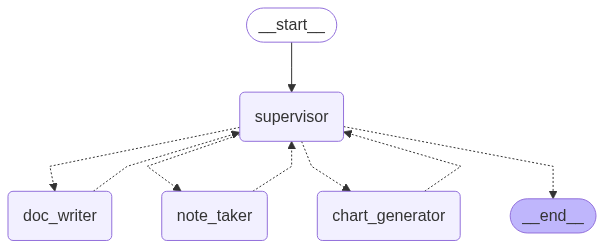

In [17]:
from IPython.display import Image, display

try:
    display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "보사노바와 삼바의 차이점을 설명하는 글의 개요를 작성하고, 텍스트 파일로 저장해주세요.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='보사노바와 삼바의 차이점을 설명하는 글의 개요가 "bossa_nova_vs_samba_outline.txt" 파일로 저장되었습니다.', additional_kwargs={}, response_metadata={}, name='note_taker', id='e8cdebe6-a576-489e-aafe-f378e85eae77')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='보사노바와 삼바의 차이점을 설명하는 글의 개요가 "bossa_nova_vs_samba_outline.txt" 파일로 저장되었습니다.', additional_kwargs={}, response_metadata={}, name='doc_writer', id='0ab08dd6-8010-4429-91f1-21c70bd1be22')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='보사노바와 삼바의 차이점을 설명하는 글의 개요가 "bossa_nova_vs_samba_outline.txt" 파일로 저장되었습니다.', additional_kwargs={}, response_metadata={}, name='doc_writer', id='06ea4f15-b5a3-4209-bf26-5c885486047b')]}}
---
{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='보사노바와 삼바의 차이점을 설명하는 글의 개요가 "bossa_nova_vs_samba_outline.t

### 대장 Supervisor Agent 생성하기

In [16]:
llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [17]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor", # 큰 Supervisor
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

In [18]:
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

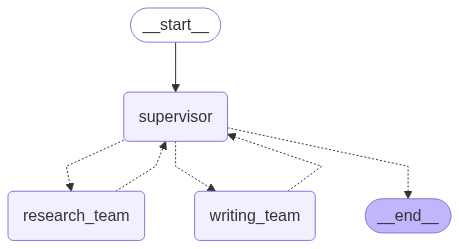

In [22]:
from IPython.display import Image, display

try:
    display(Image(super_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

테스트 !

In [23]:
for team, chunk in super_graph.stream(
    {
        "messages": [
            ("user", "https://n.news.naver.com/mnews/article/018/0006019640 이 뉴스기사의 내용을 받아와서, 텍스트 파일로 정리하고 저장해주세요. 한글로 작성해주세요.")
        ]
    },
    {"recursion_limit": 150},
    subgraphs=True, 
    stream_mode="updates",
):  
    for node, state_value in chunk.items():
        print(f"👉 Node: {node}")
        if state_value.get("messages"):
            for msg in state_value["messages"]:
                msg.pretty_print()

👉 Node: supervisor
👉 Node: supervisor
👉 Node: agent
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_7Yp0LSSUxqFOwmfFvRXpUK7i)
 Call ID: call_7Yp0LSSUxqFOwmfFvRXpUK7i
  Args:
    urls: ['https://n.news.naver.com/mnews/article/018/0006019640']
👉 Node: tools
================================= Tool Message =================================
Name: scrape_webpages

<Document name="갑자기 찾아온 여름…오늘 서울 아침, 역대 5월 중 가장 더웠다">




















갑자기 찾아온 여름…오늘 서울 아침, 역대 5월 중 가장 더웠다














본문 바로가기






NAVER

뉴스


엔터




스포츠




날씨




프리미엄




대선










검색










언론사별


정치


경제


사회


생활/문화


IT/과학


세계


랭킹


신문보기


오피니언


TV


팩트체크


알고리즘 안내


정정보도 모음
















이데일리

이데일리


구독

이데일리 언론사 구독되었습니다. 메인 뉴스판에서  주요뉴스를  볼 수 있습니다.
보러가기


이데일리 언론사 구독 해지되었습니다.




갑자기 찾아온 여름…오늘 서울 아침, 역대 5월 중 가장 더웠다




입력2025.05.21. 오전 10:31

기사원문
 

이영민 기자







이영민 기자




이영민 기자

구독
구독중




구독자
0


응원수
0



더보기














추천




쏠쏠정보

In [19]:
for team, chunk in super_graph.stream(
    {
        "messages": [
            ("user", "AI Agent에 대해 조사한 후, 조사를 완료하면 파일 작성 Agent를 통해 AI Agent의 개념 도서의 목차(장-절 구성)를 제안하여 텍스트 파일로 저장하세요.")
        ]
    },
    {"recursion_limit": 150},
    subgraphs=True, 
    stream_mode="updates",
):  
    for node, state_value in chunk.items():
        print(f"👉 Node: {node}")
        if state_value.get("messages"):
            for msg in state_value["messages"]:
                msg.pretty_print()

👉 Node: supervisor
👉 Node: supervisor
👉 Node: agent
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_0ktzPQxKSQJ59LyRviOBGRdS)
 Call ID: call_0ktzPQxKSQJ59LyRviOBGRdS
  Args:
    query: AI Agent concept
👉 Node: tools
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "What are AI Agents?- Agents in Artificial Intelligence Explained - AWS", "url": "https://aws.amazon.com/what-is/ai-agents/", "content": "An artificial intelligence (AI) agent is a software program that can interact with its environment, collect data, and use the data to perform self-determined tasks to meet predetermined goals. Humans set goals, but an AI agent independently chooses the best actions it needs to perform to achieve those goals. For example, consider a contact center AI agent that wants to resolves customer queries. The agent will automatically ask the cust

In [20]:
for team, chunk in super_graph.stream(
    {
        "messages": [
            ("user", "샘플 텍스트 파일을 만들고, 1번째 줄에 'Hello World'를 추가하세요."),
        ]
    },
    {"recursion_limit": 150},
    subgraphs=True, 
    stream_mode="updates",
):  
    for node, state_value in chunk.items():
        print(f"👉 Node: {node}")
        if state_value.get("messages"):
            for msg in state_value["messages"]:
                msg.pretty_print()

👉 Node: supervisor
👉 Node: supervisor
👉 Node: agent
================================== Ai Message ==================================
Tool Calls:
  write_document (call_a1AlsKdSUzXgHzlcTaC8P1oh)
 Call ID: call_a1AlsKdSUzXgHzlcTaC8P1oh
  Args:
    content: This is a sample text file. It illustrates the use of document creation and editing.
    file_name: sample_text_file.txt
👉 Node: tools
================================= Tool Message =================================
Name: write_document

Document saved to sample_text_file.txt
👉 Node: agent
================================== Ai Message ==================================
Tool Calls:
  edit_document (call_68Ff6Ezg3fDx2MQl0NozvZpo)
 Call ID: call_68Ff6Ezg3fDx2MQl0NozvZpo
  Args:
    file_name: sample_text_file.txt
👉 Node: tools
================================= Tool Message =================================
Name: edit_document

Error: 1 validation error for edit_document
inserts
  Field required [type=missing, input_value={'file_name': 'sa